In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import country_converter as coco
from matplotlib import pyplot as plt
from itertools import cycle, islice

save_figs_flag = True
EDITIONS = ["2000", "2001", "2002", "2003", "2004",
            "2005", "2006", "2007", "2008", "2009", 
            "2010", "2011", "2012", "2013", "2014",
            "2015", "2016", "2017", "2018", "2019",
            "2020", "2021", "2022", "2023", "2024"]

COLOR_LIST = ['darkblue', 'mediumblue', 'cornflowerblue', 
              'darkred', 'red', 'tomato', 'lightsalmon']

In [2]:
df = pd.read_csv("data/ismir_all_papers.csv")
un_cat = pd.read_csv("data/UN_categorization.csv")[['ISO Code', 'Economic Category']]
iso_to_category = dict(zip(un_cat['ISO Code'], un_cat['Economic Category']))

def map_countries_to_categories(iso_list):
    return ', '.join([iso_to_category.get(iso.strip(), 'Unknown') for iso in iso_list.split(',')])

df['Affiliation country'] = df['Authors with Affiliations'].apply(lambda x: ', '.join([entry.split('>')[1] for entry in x.split(';')]))
df['Affiliation type'] = df['Authors with Affiliations'].apply(lambda x: ', '.join([entry.split('>')[-1] for entry in x.split(';')]))
df['UN Categories'] = df['Affiliation country'].apply(map_countries_to_categories)

i = 1000
print(df.iloc[i]['Authors with Affiliations'])
print(df.iloc[i]['Affiliation country'])
print(df.iloc[i]['Affiliation type'])

df.head()


Balaji Thoshkahna+Indian Institute of Science>IND>education;Francois Xavier Nsabimana+Fraunhofer Institute of Digital Media Technology>DEU>facility;K.R. Ramakrishnan+Indian Institute of Science>IND>education
IND, DEU, IND
education, facility, education


,conference_index,Authors,Title,Year,Link,Authors with Affiliations,Abstract,first_country,first_aff_cat,first_aff_cat_UN,...,abstract_tsne_2d,title_tsne_3d,abstract_tsne_3d,title_umap_2d,abstract_umap_2d,title_umap_3d,abstract_umap_3d,Affiliation country,Affiliation type,UN Categories
0,15,Perfecto Herrera-Boyer;Xavier Amatriain;Eloi B...,Towards Instrument Segmentation for Music Cont...,2000,https://doi.org/10.5281/zenodo.1416768,Perfecto Herrera+Audiovisual Institute - Pompe...,A system capable of describing the musical con...,ESP,education,Developed economies,...,"[3.1705327, -12.8276415]","[20.477497, -4.0411277, -18.56773]","[13.273217, 0.19922031, -8.516665]","[8.600878, 8.404931]","[9.565406, 2.2991855]","[12.615438, 9.365253, -1.9493338]","[10.903186, 7.1374574, 11.25885]","ESP, ESP, ESP, ESP","education, education, education, education","Developed economies, Developed economies, Deve..."
1,33,Alexandra L. Uitdenbogerd;Justin Zobel,Music Ranking Techniques Evaluated.,2000,https://doi.org/10.5281/zenodo.1414990,Alexandra L. Uitdenbogerd+RMIT University>AUS>...,Several techniques have been proposed for matc...,AUS,education,Developed economies,...,"[23.650671, -12.440616]","[-8.786249, 8.753312, -7.6994915]","[7.7473493, -10.501352, 8.463312]","[13.837959, 7.1572523]","[11.020011, -0.25071612]","[15.7918415, 7.986932, -1.1284965]","[11.289102, 5.079816, 14.183715]","AUS, AUS","education, education","Developed economies, Developed economies"
2,32,Alexandra L. Uitdenbogerd,"Music IR: Past, Present, and Future.",2000,https://doi.org/10.5281/zenodo.1417545,Alexandra L. Uitdenbogerd+RMIT University>AUS>...,Music Information Retrieval has a longer histo...,AUS,education,Developed economies,...,"[24.683052, 1.216263]","[-11.697868, 21.503635, -5.8990464]","[3.667515, -6.047719, 8.387314]","[14.030799, 6.2451067]","[11.492729, 0.28146976]","[15.834118, 7.159758, -1.6523566]","[11.634125, 5.052472, 13.80562]","AUS, AUS, AUS","education, education, education","Developed economies, Developed economies, Deve..."
3,29,Jochen Schimmelpfennig;Frank Kurth,MCML - Music Contents Markup Language.,2000,https://doi.org/10.5281/zenodo.1415526,Jochen Schimmelpfennig+University of Bonn>DEU>...,We present an XML-based description interface ...,DEU,education,Developed economies,...,"[5.692757, 27.776169]","[-0.7090279, 17.623865, -14.180176]","[-3.1960096, -8.358783, 20.134007]","[12.5179205, 5.7732697]","[12.436563, -0.2819016]","[14.523515, 6.8880763, -1.1454129]","[11.121715, 3.8818424, 12.963449]","DEU, DEU","education, education","Developed economies, Developed economies"
4,28,Perry Roland,XML4MIR: Extensible Markup Language for Music ...,2000,https://doi.org/10.5281/zenodo.1417167,Perry Roland+University of Virginia>USA>education,This paper evaluates the role of standards in ...,USA,education,Developed economies,...,"[6.5095024, 28.41491]","[-1.166108, 15.790353, -15.373351]","[-1.5860064, -7.730139, 21.785463]","[12.882296, 5.9628572]","[12.513417, -0.23882104]","[14.76004, 7.058861, -1.653147]","[11.271783, 3.7831059, 12.969235]",USA,education,Developed economies


In [3]:
df['Western_flag'] = df['Abstract'].str.lower().str.contains('western').astype(int)

print(df['Western_flag'].value_counts())
print(df['Western_flag'].value_counts() / df.shape[0])

Western_flag
0    2352
1     106
Name: count, dtype: int64
Western_flag
0    0.956876
1    0.043124
Name: count, dtype: float64


['Developed economies' 'Developing economies' 'Unknown'
 'Economies in transition']


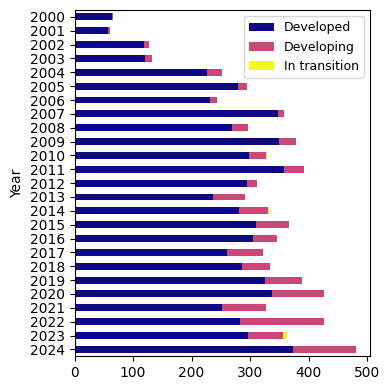

Category
Developed economies        85.831917
Developing economies       14.037381
Economies in transition     0.130702
dtype: float64

In [4]:
# plot developing economies through time

venues = ['USA', 'USA', 'FRA', 'USA', 'ESP', 'GBR', 
          'CAN', 'AUT', 'USA', 'JPN', 'NLD', 'USA', 
          'PRT', 'BRA', 'TWN', 'ESP', 'USA', 'CHN', 
          'FRA', 'NLD', 'CAN (o)', 'Online', 'IND (h)', 
          'ITA (h)', 'USA (h)']

print(df['UN Categories'].str.split(',').explode().str.strip().unique())

def count_categories(df):
    category_counts = []
    
    for _, row in df.iterrows():
        year = row['Year']
        try: 
            categories = row['UN Categories'].split(', ')
        except:
            categories = ['Unknown']
        
        filtered_categories = [cat.strip() for cat in categories if cat != 'Unknown']

        category_counts.append(pd.DataFrame({'Year': year, 'Category': filtered_categories}))

    category_df = pd.concat(category_counts)
    return category_df.groupby(['Year', 'Category']).size().unstack(fill_value=0)

# Get category counts per year
category_counts = count_categories(df)

category_counts.plot(kind='barh', stacked=True, figsize=(4, 4), colormap='plasma')
custom_labels = ['Developed', 'Developing', 'In transition']
plt.legend(labels=custom_labels, fontsize=9, loc='upper right')
plt.gca().invert_yaxis()
plt.tight_layout()
if save_figs_flag:
    plt.savefig("figs/aff_un_type.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# percentages of participation
category_counts.sum() * 100/ category_counts.sum().sum()

In [5]:
type_e = 0
type_f = 0
type_c = 0
type_ef = 0
type_ec = 0
type_fc = 0
type_efc = 0

type_lists = []

typeDict = {}
countryDict = {}

country_names = set()

for ed in EDITIONS:
    # print("###",ed)

    dfISMIRyear = df[df["Year"] == int(ed)]
    countryDict[ed] = {}

    for index, row in dfISMIRyear.iterrows():

        aff_types = [x.strip() for x in row["Affiliation type"].split(",")]
        aff_countries = [x.strip() for x in row["Affiliation country"].split(",")]

        # Check list lenghts
        it = iter([aff_types,aff_countries])
        the_len = len(next(it))
        if not all(len(l) == the_len for l in it):
             raise ValueError('not all lists have same length!')

        # Aff types
        if len(set(aff_types)) == 1:
            if "education" in aff_types:
                type_e += 1
            elif "facility" in aff_types:
                type_f += 1
            elif "company" in aff_types:
                type_c += 1
        elif len(set(aff_types)) == 2:
            if "education" in aff_types and "facility" in aff_types:
                type_ef += 1
            elif "education" in aff_types and "company" in aff_types:
                type_ec += 1
            elif "facility" in aff_types and "company" in aff_types:
                type_fc += 1
        elif len(set(aff_types)) == 3:
            type_efc += 1


        # Aff countries
        if len(set(aff_countries)) == 1:
            co = next(iter(set(aff_countries)))
            country_names.add(co)
            if co not in countryDict[ed]:
                countryDict[ed][co] = {"sc":1, "mc":0}
            else:
                countryDict[ed][co]["sc"] += 1
        else:
            for co in set(aff_countries):
                country_names.add(co)
                if co not in countryDict[ed]:
                    countryDict[ed][co] = {"sc":0, "mc":1}
                else:
                    countryDict[ed][co]["mc"] += 1



    type_list = [type_e, type_f, type_c, type_ef, type_ec, type_fc, type_efc]
    type_list_perc = [round(x*100/np.sum(type_list), 2) for x in type_list]

    typeDict[ed] = type_list_perc
    
    # print(type_list)
    # print(type_list_perc)
    # print(len(dfISMIRyear), len(countryDict[ed]))

CountryCountDict = {}
for co in country_names:
    if co == 'unknown':
        continue
    CountryCountDict[co] = [0,0]
    for ed in EDITIONS:
        if co in countryDict[ed]:
            CountryCountDict[co][0] += countryDict[ed][co]['sc']
            CountryCountDict[co][1] += countryDict[ed][co]['mc']

# Sort Dict Countries
temp1 = {val: sum(int(idx) for idx in key) 
           for val, key in CountryCountDict.items()}
# using sorted to perform sorting as required
temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]], reverse=True)
# rearrange into dictionary
CountryCountDictSorted = {key: CountryCountDict[key] for key, val in temp2 if key!="Unknown"}

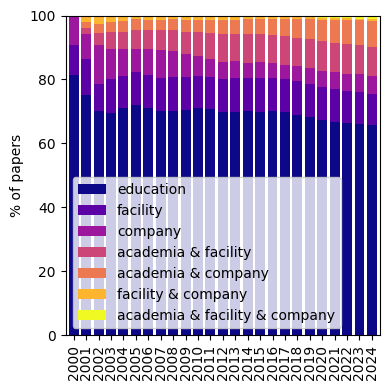

In [6]:
def plot_aff_type(typeDict):
    """
    """
    aff_df = pd.DataFrame.from_dict(typeDict, orient='index')
    #my_colors = list(islice(cycle(COLOR_LIST), None, len(aff_df)))
    #aff_df.plot(kind='bar', stacked=True, color=my_colors, width=.8)
    aff_df.plot(kind='bar', stacked=True, colormap='plasma', width=.8, figsize=(4, 4))


    plt.ylabel('% of papers')
    plt.legend(['education','facility','company',
                'academia & facility','academia & company',
                'facility & company','academia & facility & company'])

    plt.title('')
    plt.ylim([0,100])
    plt.xticks(np.arange(25), EDITIONS, rotation=90, ha='center')
    plt.tight_layout()
    if save_figs_flag:
        plt.savefig("figs/aff_type.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


plot_aff_type(typeDict)

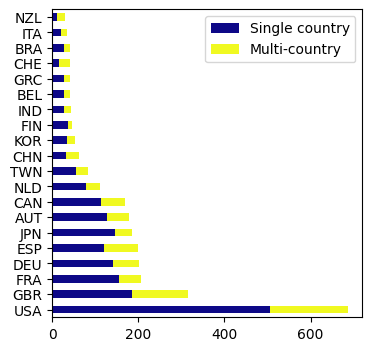

In [7]:
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
    
def plot_aff_country():
    """
    """
    aff_df = pd.DataFrame.from_dict(CountryCountDictSorted, orient='index')
    aff_df.plot(kind='barh', stacked=True, colormap='plasma', figsize=(4, 4))

    # plt.ylabel('number of papers')
    plt.legend(['Single country', 'Multi-country'])
    plt.title('')
    plt.ylim([-.5,19.5])
    plt.yticks(np.arange(20), 
                         [key for key, val in take(20,CountryCountDictSorted.items())], 
                         rotation=0)
    if save_figs_flag:
        plt.savefig("figs/top_countries.pdf", format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


plot_aff_country()


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


                      country country_code  \
0                   Indonesia          IDN   
1                    Malaysia          MYS   
2                       Chile          CHL   
3                     Bolivia          BOL   
4                        Peru          PER   
..                        ...          ...   
237                     Palau          PLW   
238                      Guam          GUM   
239  Northern Mariana Islands          MNP   
240                   Bahrain          BHR   
241               Macao S.A.R          MAC   

                                              geometry iso2_code Country  \
0    MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...        ID     NaN   
1    MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...        MY     MYS   
2    MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...        CL     NaN   
3    POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...        BO     NaN   
4    MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...        PE   

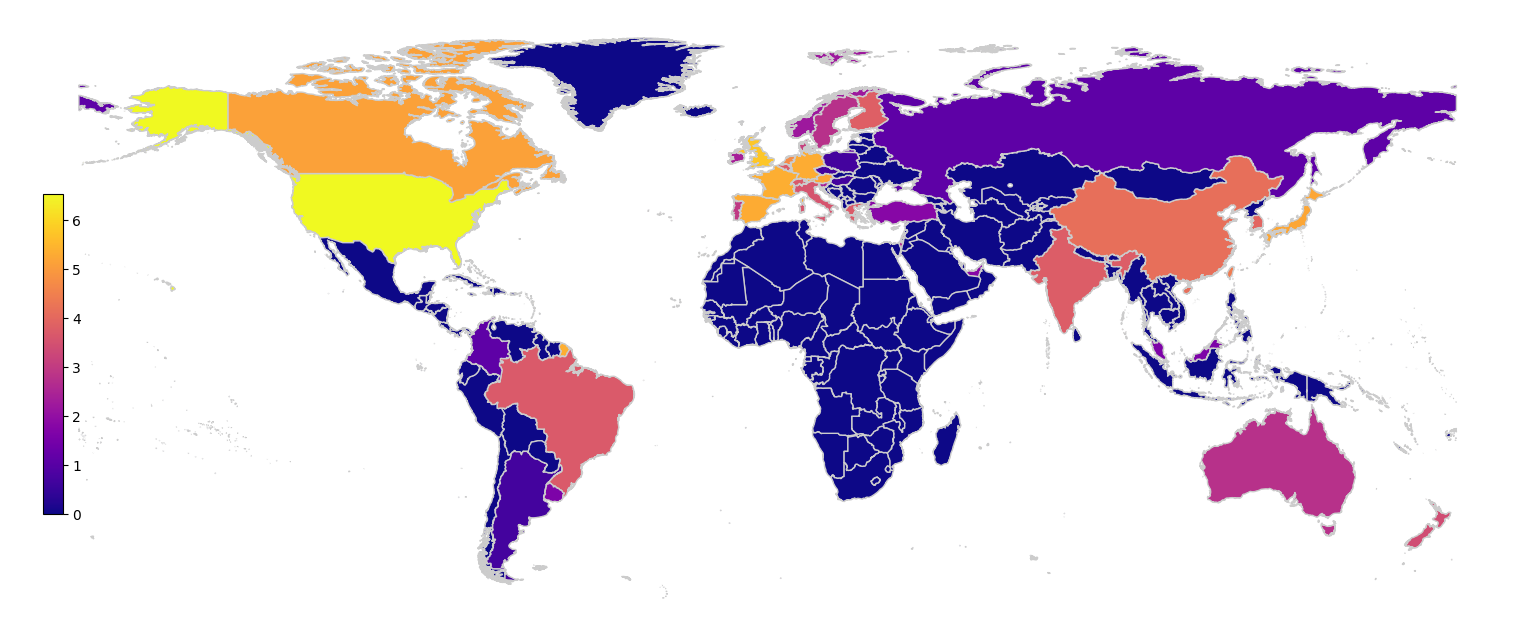

In [8]:
def plot_worldmap():
    """
    """
    # Setting the path to the shapefile
    SHAPEFILE = 'data/worldmap/ne_10m_admin_0_countries.shp'
    # Read shapefile using Geopandas
    geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
    # Rename columns.
    geo_df.columns = ['country', 'country_code', 'geometry']
    geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)


    iso3_codes = geo_df['country'].to_list()
    # Convert to iso3_codes
    iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
    # Add the list with iso2 codes to the dataframe
    geo_df['iso2_code'] = iso2_codes_list
    # There are some countries for which the converter could not find a country code. 
    # We will drop these countries.
    geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


    CountryCountDictPlot = {key: val for key, val in temp2 if key!="unknown"}
    country_df = pd.DataFrame(list(CountryCountDictPlot.items()), columns=['Country', 'Value'])

    merged_df = pd.merge(left=geo_df, right=country_df, how='left', left_on='country_code', right_on='Country')

    merged_df["Value"].fillna(1, inplace=True)

    merged_df["Value"] = np.log(merged_df["Value"])
    print(merged_df)

    col = 'Value'
    vmin = merged_df[col].min()
    vmax = merged_df[col].max()
    cmap = 'plasma'
    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))
    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    # Empty array for the data range
    sm._A = []
    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)

    if save_figs_flag:
        plt.savefig("figs/worldmap_log.pdf", format="pdf", bbox_inches="tight")
    plt.show()


plot_worldmap()

## Measuring Diversity and Inequality

This section uses the data of affiliation country to measure inequality (based on the Gini index) and diversity (based on Shannon's entropy and Pielou Evenness index). We take into account a list of all countries in the list of ISO3166 country codes to calculate Gini. 

In [9]:
all_ismir = df['Affiliation country'].dropna().str.split(',').explode().str.strip().unique().tolist()
all_ismir.remove('Unknown')
print(all_ismir)

full_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWZ', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']
print(full_list)

countries = df[df['Year'] == 2001]['Affiliation country'].dropna().str.split(',').explode().str.strip()
country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
import numpy as np
array = np.sort(np.array(country_counts))[::-1]
index = np.arange(1, array.shape[0] + 1)
print(array, index)

['ESP', 'AUS', 'DEU', 'USA', 'GBR', 'NZL', 'FIN', 'MYS', 'JPN', 'GRC', 'FRA', 'POL', 'TWN', 'ITA', 'IRL', 'CAN', 'BEL', 'CHN', 'NLD', 'SVN', 'AUT', 'KOR', 'SGP', 'NOR', 'ISR', 'CHE', 'BRA', 'ROU', 'DNK', 'PRT', 'VEN', 'HUN', 'OMN', 'URY', 'HKG', 'SRB', 'IND', 'IRN', 'EWN', 'TUR', 'SWE', 'CYP', 'ARE', 'RUS', 'CZE', 'COL', 'EST', 'ARG', 'VNM']
['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB

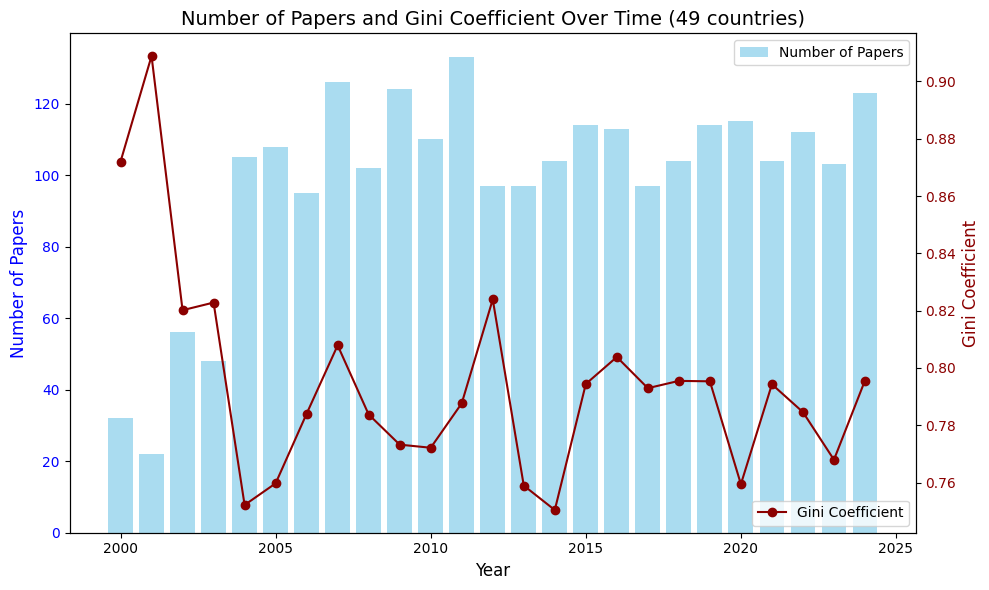

In [10]:
import seaborn as sns
import numpy as np


def gini(array):
    array = np.array(array, dtype=np.float64)
    
    if np.any(array < 0):
        raise ValueError('Negative values!')
    
    if np.sum(array) == 0:
        return 0.0  # If all values are zero, return 0

    array = np.sort(array)  
    cumulative = np.cumsum(array)
    sum_y = cumulative[-1]

    n = array.shape[0]
    gini_coeff = (2 * np.sum((np.arange(1, n + 1) * array)) / sum_y - (n + 1)) / n
    return gini_coeff

gini_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    # using full list of 48 countries to calculate Gini 
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    gini_coeff = gini(country_counts)
    gini_data.append((year, gini_coeff))

gini_df = pd.DataFrame(gini_data, columns=['Year', 'Gini_Coefficient'])
yearly_counts = df['Year'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'Number of Papers and Gini Coefficient Over Time ({len(all_ismir)} countries)', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(gini_df['Year'], gini_df['Gini_Coefficient'], color='darkred', marker='o', label='Gini Coefficient')
ax2.set_ylabel('Gini Coefficient', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
if save_figs_flag:
    plt.savefig(f"figs/gini_{len(all_ismir)}countries.pdf", format="pdf", bbox_inches="tight")
plt.show()

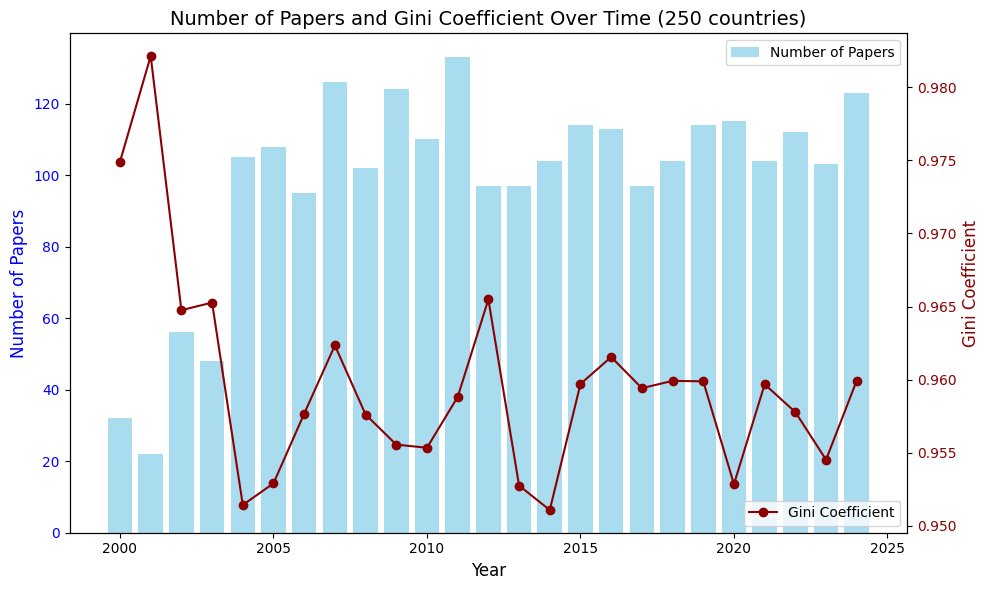

In [11]:
gini_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    # using full list of 250 countries to calculate Gini 
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(full_list, fill_value=0)
    gini_coeff = gini(country_counts)
    gini_data.append((year, gini_coeff))

gini_df = pd.DataFrame(gini_data, columns=['Year', 'Gini_Coefficient'])
yearly_counts = df['Year'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'Number of Papers and Gini Coefficient Over Time ({len(full_list)} countries)', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(gini_df['Year'], gini_df['Gini_Coefficient'], color='darkred', marker='o', label='Gini Coefficient')
ax2.set_ylabel('Gini Coefficient', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
if save_figs_flag:
    plt.savefig(f"figs/gini_{len(full_list)}countries.pdf", format="pdf", bbox_inches="tight")
plt.show()

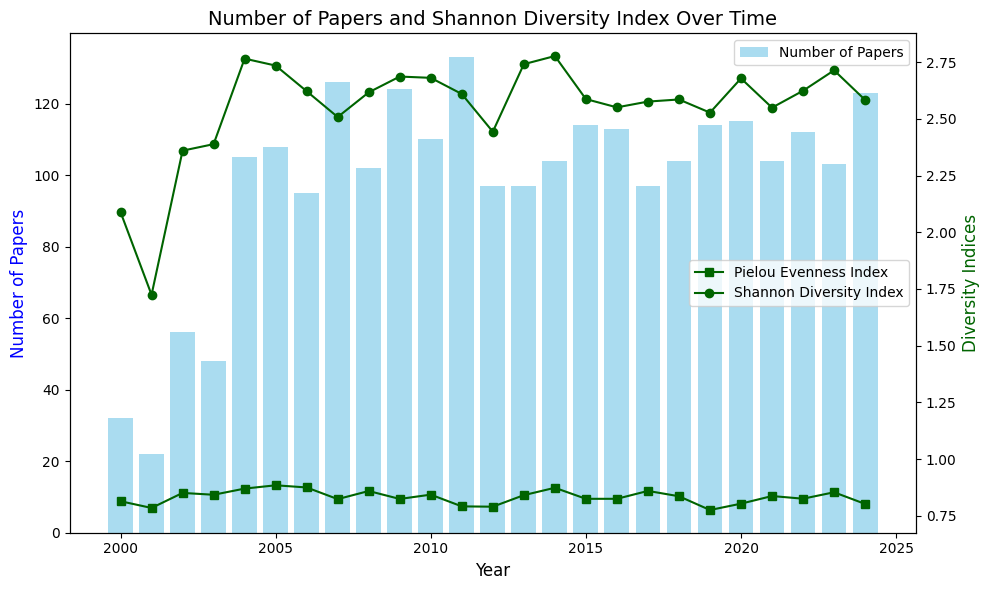

In [12]:
from scipy.stats import entropy

shannon_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    S = (country_counts > 0).sum()  # Number of unique countries
    shannon_ent = entropy(country_counts) if S > 0 else np.nan
    # calculate pielou index
    pielou_evenness = shannon_ent / np.log(S) if S > 1 else np.nan
    shannon_data.append((year, shannon_ent, pielou_evenness))

    
shannon_df = pd.DataFrame(shannon_data, columns=['Year', 'Shannon_Diversity_Index', 'Pielou_Evenness'])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y')
ax1.set_title('Number of Papers and Shannon Diversity Index Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(shannon_df['Year'], shannon_df['Pielou_Evenness'], color='darkgreen', marker='s', label='Pielou Evenness Index')
ax2.plot(shannon_df['Year'], shannon_df['Shannon_Diversity_Index'], color='darkgreen', marker='o', label='Shannon Diversity Index')
ax2.set_ylabel('Diversity Indices', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y')

ax1.legend(loc='upper right')
ax2.legend(loc='center right')
plt.tight_layout()
if save_figs_flag:
    plt.savefig("figs/shannon_pielou.pdf", format="pdf", bbox_inches="tight")
plt.show()

Case Gini:
Y=β0+β1*X+ϵ = 1.781030078221098 + -0.00040819911830056996 X + 0.00018089099229960914
Stats: slope=-0.00040819911830056996, t=-2.2566027921637533, p=0.033840035963419605 -> the model explains 18.126903486526484% of the variance
Case Pielou:
Y=β0+β1*X+ϵ = 2.4723089420499678 + -0.0008149340451123591 X + 0.0008321642843276727
Stats: slope=-0.0008149340451123591, t=-0.9792946662818697, p=0.33762361349412606 -> the model explains 4.002743525091898% of the variance


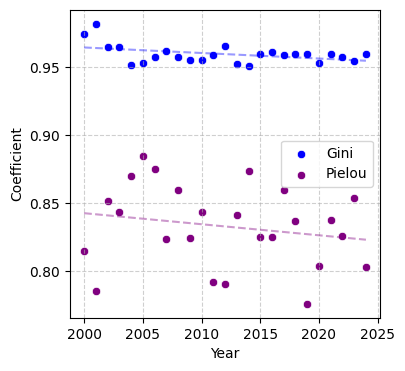

In [13]:
from scipy.stats import linregress
import seaborn as sns

combined_df = pd.merge(gini_df, shannon_df, on='Year', how='inner')
combined_df.rename(columns={'Gini_Coefficient': 'Gini', 'Shannon_Diversity_Index': 'Shannon', 'Pielou_Evenness': 'Pielou'}, inplace=True)

fig, ax = plt.subplots(figsize=(4, 4))

#colors = {'Gini': 'blue', 'Pielou': 'purple', 'Shannon': 'red'}
colors = {
    'Gini': 'blue',
    'Pielou': 'purple'
}


for col, color in colors.items():
    sns.scatterplot(x=combined_df['Year'], y=combined_df[col], label=col, color=color, ax=ax)
    slope, intercept, r_value, p_value, std_err = linregress(combined_df['Year'], combined_df[col])
    reg_line = combined_df['Year'] * slope + intercept
    y_pred = combined_df['Year'] * slope + intercept
    residuals = combined_df[col] - y_pred
    std_dev = np.std(residuals)
    ax.plot(combined_df['Year'], reg_line, color=color, linestyle='--', alpha=0.4)
    # ax.fill_between(combined_df['Year'], reg_line - std_dev, reg_line + std_dev, color=color, alpha=0.2)
    r_squared = r_value ** 2
    t_stat = slope / std_err
    # Y=β0+β1*X+ϵ
    print(f'Case {col}:')
    print(f'Y=β0+β1*X+ϵ = {intercept} + {slope} X + {std_err}')
    print(f'Stats: slope={slope}, t={t_stat}, p={p_value} -> the model explains {r_squared*100}% of the variance')
    
    last_x = combined_df['Year'].max()
    last_y = last_x * slope + intercept  # Compute last Y point
    #ax.text(last_x, last_y, f'p={p_value:.4f}', fontsize=10, color=color, ha='left', va='bottom', fontweight='bold')

ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Coefficient', fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

if save_figs_flag:
    plt.savefig("figs/gini_pielou.pdf", format="pdf", bbox_inches="tight", dpi=300)

plt.show()

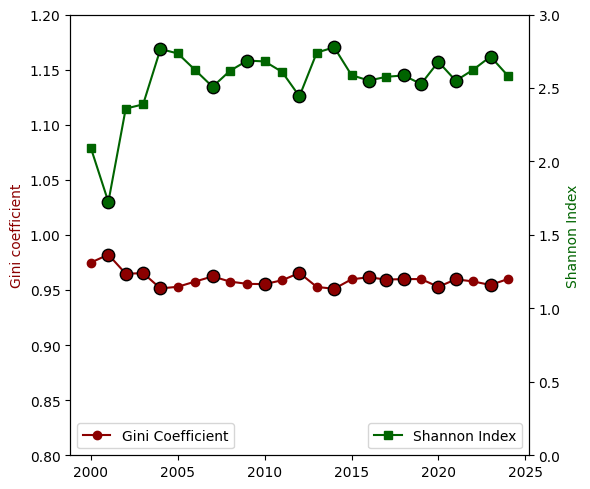

In [14]:
import scipy.signal

def find_extrema(series):
    maxima = scipy.signal.argrelextrema(series.values, np.greater)[0]  # Peaks
    minima = scipy.signal.argrelextrema(series.values, np.less)[0]  # Dips
    return series.iloc[maxima], series.iloc[minima]

gini_peaks, gini_dips = find_extrema(combined_df.set_index('Year')['Gini'])
shannon_peaks, shannon_dips = find_extrema(combined_df.set_index('Year')['Shannon'])


fig, ax1 = plt.subplots(figsize=(6, 5))

ax1.plot(combined_df['Year'], combined_df['Gini'], 
         color='darkred', marker='o', label='Gini Coefficient')
#ax1.set_title('Diversity Indices with Peaks and Dips', fontsize=14)
for series, color, label in [(gini_peaks, 'darkred', 'Gini Peak'), 
                              (gini_dips, 'darkred', 'Gini Dip')]:
    for year, value in series.items():
        ax1.scatter(year, value, color=color, s=80, edgecolors='black', zorder=3)  # Highlight points
        #ax1.text(year, value, f"{year}\n{value:.2f}", fontsize=10, 
        #         ha='center', va='bottom' if 'Peak' in label else 'top', 
        #         color=color, fontweight='bold')
ax1.set_ylabel('Gini coefficient', fontsize=10, color='darkred')
ax1.set_ylim([0.8, 1.2])


ax2 = ax1.twinx()
ax2.plot(combined_df['Year'], combined_df['Shannon'], 
         color='darkgreen', marker='s', label='Shannon Index')

for series, color, label in [(shannon_peaks, 'darkgreen', 'Shannon Peak'), 
                              (shannon_dips, 'darkgreen', 'Shannon Dip')]:
    for year, value in series.items():
        ax2.scatter(year, value, color=color, s=80, edgecolors='black', zorder=3)  # Highlight points
        #ax2.text(year, value, f"{year}\n{value:.2f}", fontsize=8, 
        #         ha='center', va='bottom' if 'Peak' in label else 'top', 
        #         color=color, fontweight='bold')

ax2.set_ylabel('Shannon Index', fontsize=10, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 3])

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')
plt.tight_layout()
if save_figs_flag:
    plt.savefig("figs/local_variations_gini_shannon.pdf", format="pdf", bbox_inches="tight")
plt.show()



A dip in Shannon and a peak in Gini suggests increasing concentration / decreasing diversity.
- 2001, 2007, 2012, 2019, 2021

A peak in Shannon and a dip in Gini suggests decreasing concentration / increasing diversity.
- 2004, 2009, 2014, 2020, 2023


## Network analysis
Analyze the co-authorship or affiliation networks for geographic and institutional diversity. We use bipartite networks to understand the relationship between authors and affiliations. 

In [15]:
import networkx as nx
from pyvis.network import Network

edges = []
for _, row in df.iterrows():
    authors = row['Authors'].split(';')  # Split authors
    countries = row['Affiliation country'].split(',')  # Split country codes
    for author, country in zip(authors, countries):
        edges.append((author.strip(), country.strip()))  # Add edges between authors and countries

B = nx.Graph()
B.add_edges_from(edges)
authors = {node for node, degree in B.degree if any(node in edge for edge in edges)}
countries = set(B) - authors

# compute centrality and node sizes
degree_centrality = nx.degree_centrality(B)
node_size = {node: degree_centrality[node] * 50 for node in B.nodes}  # Scale size for Pyvis
country_size = {node: degree_centrality[node] * 100 for node in countries}  # Larger size for countries

net = Network(notebook=True, height="800px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')
net.force_atlas_2based(gravity=-1000, central_gravity=0.01, spring_length=100, spring_strength=0.01, damping=0.1) 

for node in B.nodes:
    color = "lightblue" if node in authors else "darkblue"  
    size = node_size.get(node, 5) + 5 
    if node in countries:
        size = country_size.get(node, 100) + 30  
        color = "lightgreen"  # Change country color for contrast

    net.add_node(
        node, 
        label=node, 
        size=size, 
        color=color,
        title=f"Node: {node}"  # Hover tooltip with node name
    )


for edge in B.edges:
    net.add_edge(*edge, color="lightblue", width=0.5)
# net.show("author_country_network.html")
net.write_html("author_country_network.html")

In [16]:
communities = nx.community.louvain_communities(B, seed=1987)
all_authors = df['Authors'].dropna().str.split(';').explode().str.strip().unique().tolist()

# Print the communities
print("Louvain Communities:")
cnt_single = 0
cnt_multi = 0
for i, comm in enumerate(communities):
    
    this_country = [_ for _ in comm if _ in all_ismir]
    th_authors = [_ for _ in comm if _ in all_authors]
    if len(this_country) > 1:
        print('-----------------------------------------------')
        print('------------Inter-country community------------')
        print('-----------------------------------------------')
        print(f'Community {this_country}:\n{th_authors}')
        cnt_multi += 1
    else:
        cnt_single += 1
    
    
    # print(f'Community {this_country}:\n{th_authors}')
print('-----------------------------------------------')
print('--------------------SUMMARY--------------------')
print('-----------------------------------------------')
print(f'Single-country communities: {cnt_single}/{i} ({cnt_single/i*100}%)')
print(f'Multi-country communities: {cnt_multi}/{i} ({cnt_multi/i*100}%)')
        


Louvain Communities:
-----------------------------------------------
------------Inter-country community------------
-----------------------------------------------
Community ['URY', 'ESP']:
['Pedro Ramoneda', 'Ana M. Barbancho', 'Andreas F. Ehmann', 'Alicia Fornés', 'Andres Ferraro', 'Ignacio Irigaray', 'Jordi Pons', 'Izaro Goienetxea', 'Pedro Vera-Candeas', 'David García', 'Roser Batlle-Roca', 'Noelia N. Luna-Barahona', 'Jordi Bonada', 'Błażej Kotowski', 'Jorge Morato', 'Pablo Cabañas Molero', 'Albin Correya', 'María Alfaro-Contreras', 'Erik M. Schmidt', 'Josep Lluís Arcos', 'Jordi Massaguer', 'Haldo Sponton', 'Benno Weck', 'Iván López-Espejo', 'Massimiliano Zanin', 'Philip Tovstogan', 'Sergio I. Giraldo', 'Sebastian García Galán', 'Horacio Saggion', 'J. Enrique Muñoz Expósito', 'Hendrik Purwins', 'Mohamed Sordo', 'Pedro Cano', 'Ángel Faraldo', 'Pablo Alonso-Jiménez', 'Francisco J. Castellanos', 'Martín Rocamora', 'Francisco Gómez 0001', 'Pau Torras', 'Helena Bantulà', 'Patricia Garc

It seems that very few affiliations are able to trascend single-country communities. Moreover, most of the multi-country communities are very focused in Europe: Romania-Finland, Estonia-Cyprus-Netherlands, Denmark-Norway-Portugal , Italy-Austria, Poland-Great Britain, Czech Republic-Switzerland.

Other communities that are not as western-centered are Uruguay-Spain, Turkey-Norway-United Arab Emirates-Portugal-Sweden, China-Hong Kong.

# Wordclouds

This could be related more to general topics as discussed by Perfecto Herrera in his PhD Thesis:
- 2000-2004: age of feature extractors
- 2004-2009: age of semantic content
- 2009-2014: age of context-aware systems
- 2014-today: age of creative systems


In [17]:
# Define time periods
time_ranges = [(2000, 2004), (2004, 2009), (2009, 2014), (2014, 2025)]
un_cat = pd.read_csv("data/UN_categorization.csv")[['ISO Code', 'Location 1']]
iso_to_category = dict(zip(un_cat['ISO Code'], un_cat['Location 1']))

def map_countries_to_categories(iso_list):
    return ', '.join([iso_to_category.get(iso.strip(), 'Unknown') for iso in iso_list.split(',')])


df['Location'] = df['Affiliation country'].apply(map_countries_to_categories)

In [18]:
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

custom_stopwords = set(['music', 'audio', 'using', 'musical', 'retrieval', 'analysis', 'based', 'automatic', 'information'])
stopwords = STOPWORDS.union(custom_stopwords)

texts = []
for start, end in time_ranges:
    texts.append(' '.join(df[(df['Year'] >= start) & (df['Year'] < end)]['Title'].dropna().tolist()))

region_colors = {
    'Asia': 'purple', 
    'Latin America': 'orange', 
    'Commonwealth of Independent States and Georgia': 'brown',
    'Developed Asia and Pacific': 'green', 
    'Northern America': 'red', 
    'Europe': 'blue', 
    'Unknown': 'gray', 
}

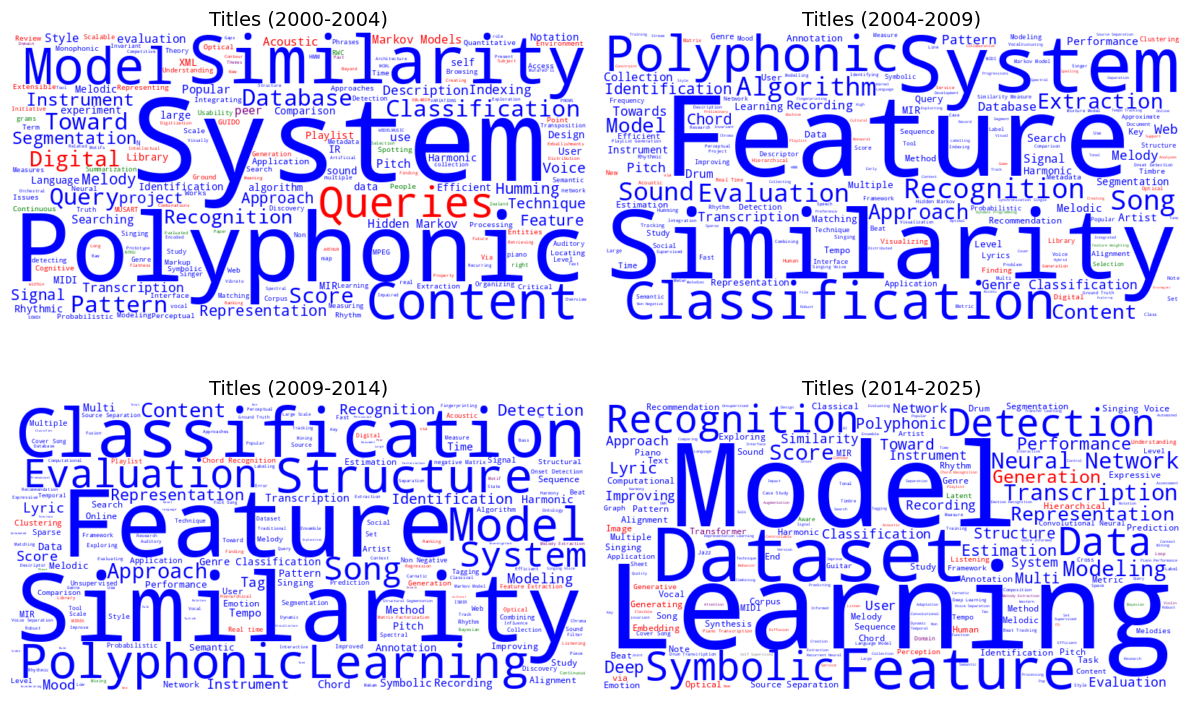

In [19]:
def get_region_color(word, df):
    locations = df[df['Title'].str.contains(word, case=False, na=False)]['Location'].dropna()
    all_regions = [region.strip() for loc in locations for region in loc.split(',')]
    if all_regions:
        most_common_region = Counter(all_regions).most_common(1)[0][0]
    else:
        most_common_region = "Unknown"
    return region_colors.get(most_common_region, "gray")

all_regions_flat = [region.strip() for loc in df['Location'].dropna() for region in loc.split(',')]
region_frequencies = Counter(all_regions_flat)
max_region_freq = max(region_frequencies.values())  # For normalization

def get_region_color_and_size(word, df):
    locations = df[df['Title'].str.contains(word, case=False, na=False)]['Location'].dropna()
    all_regions = [region.strip() for loc in locations for region in loc.split(',')]

    if all_regions:
        most_common_region = Counter(all_regions).most_common(1)[0][0]
    else:
        most_common_region = "Unknown"

    color = region_colors.get(most_common_region, "gray")

    region_freq = region_frequencies.get(most_common_region, 1)
    size_multiplier = (max_region_freq / region_freq) ** 0.2  # Increase size for rarer regions

    return color, size_multiplier


def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    color, size_multiplier = get_region_color_and_size(word, df)
    return color

# Generate word clouds with controlled placement
def generate_custom_wordcloud(text, df, vertical_position):
    def custom_position_func(word, font_size, position, orientation, random_state=None, **kwargs):
        return (random.randint(0, 800), vertical_position + random.randint(-10, 10))

    wordcloud = WordCloud(
        width=800, height=400, background_color='white', stopwords=stopwords,
        color_func=lambda word, **kwargs: get_region_color_and_size(word, df),
        prefer_horizontal=1.0, 
        relative_scaling=0.5
    ).generate(text)

    #wordcloud.recolor(color_func=lambda word, **kwargs: get_region_color_and_size(word, df))  
    wordcloud.recolor(color_func=custom_color_func)

    return wordcloud

wordclouds = []
for i, text in enumerate(texts):
    vertical_pos = int((i + 1) * 400 / len(time_ranges))  # Spread across y-axis
    wordclouds.append(generate_custom_wordcloud(text, df, vertical_pos))

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(wordclouds[i], interpolation='bilinear')
    ax.set_title(f"Titles ({time_ranges[i][0]}-{time_ranges[i][1]})", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()